In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdmpy
import statsmodels.api as sm
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(1, "./hdmpy")
import warnings
warnings.filterwarnings("ignore")

### Assignment 1

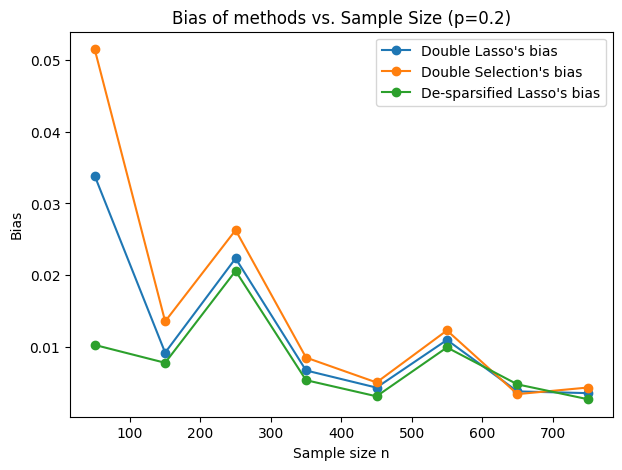

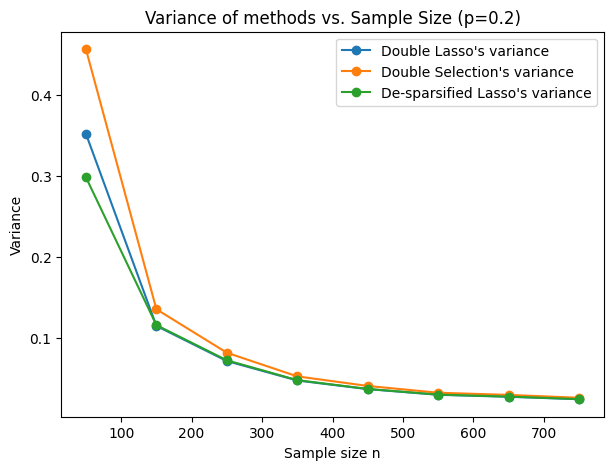

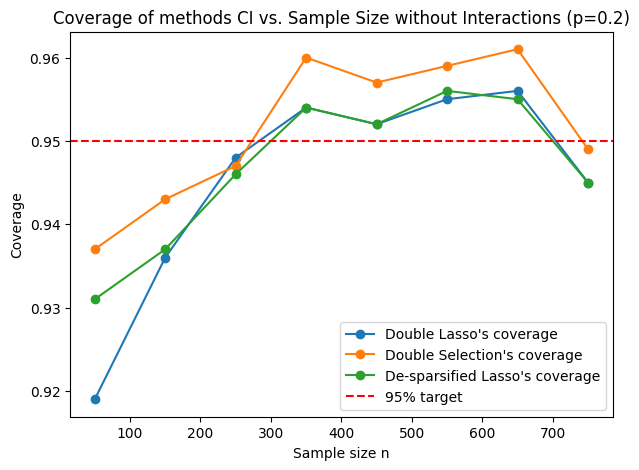

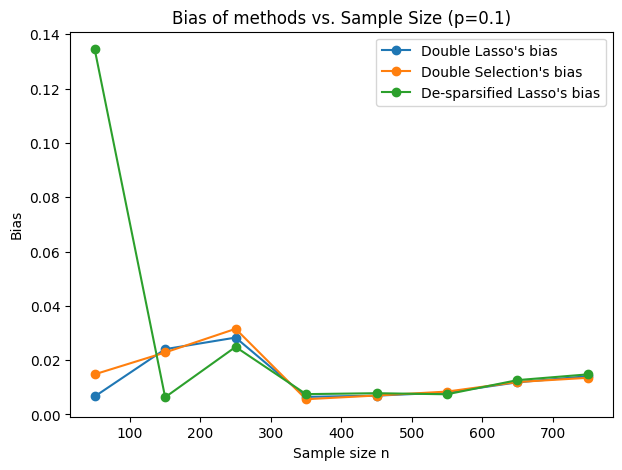

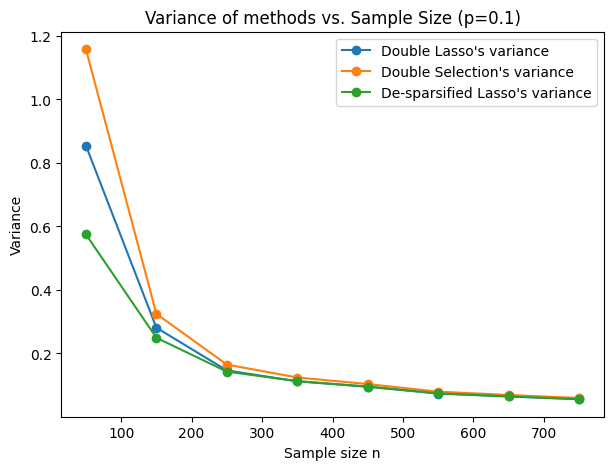

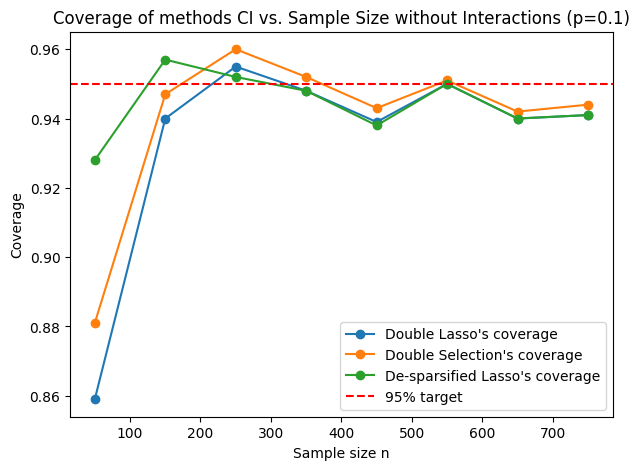

In [16]:
# c.) 

class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est["beta"]).flatten() + np.array(self.rlasso_.est["intercept"])


def lasso_model():
    return RLasso(post=False)


def gen_data(n, d, p, delta, base):
    """
    n: sample size
    d: number of covariates
    p: probability of treatment
    delta: true treatment effect
    base: baseline response
    
    Returns:
        y (n-vector): outcome
        D (n-vector): treatment indicator
        X (n x d): covariates
    """
    D = np.random.binomial(1, p, size=n)
    X = np.random.normal(0, 1, size=(n, d))
    
    # Potential outcomes:
    #  Y(0) = base - X[:,0] + noise
    #  Y(1) = delta + base + X[:,0] + noise
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=n)
    y1 = delta + base + X[:, 0] + np.random.normal(0, 1, size=n)
    
    # Observed outcome:
    y = D * y1 + (1 - D) * y0
    return y, D, X

n_grid = [50, 150, 250, 350, 450, 550, 650, 750]
reps = 1000
delta_true = 1.0      # given
d = 10                # dimensionality of X
base = 0.3            # baseline

# double selection procedure
def run_experiment(reps, delta_true, d, base, p, interactions=False):
    coverage_results_double_lasso = []
    coverage_results_double_selection = []
    coverage_results_de_sparsified_lasso = []
    tau_hats_double_lasso = []
    tau_hats_double_selection = []
    tau_hats_de_sparsified_lasso = []
    var_tau_hats_double_lasso = []
    var_tau_hats_double_selection = []
    var_tau_hats_de_sparsified_lasso = []
    for n in n_grid:
        covered_count_double_lasso = 0
        covered_count_double_selection = 0
        covered_count_de_sparsified_lasso = 0
        tau_hats_double_lasso_n = []
        tau_hats_double_selection_n = []
        tau_hats_de_sparsified_lasso_n = []
        for i in range(reps):
            y, D, X = gen_data(n, d, p, delta_true, base)
            
            tau_hat_double_lasso, se_double_lasso = double_lasso(y, D, X, interactions)
            tau_hat_double_selection, se_double_selection = double_selection(y, D, X, interactions)
            tau_hat_de_sparsified_lasso, se_de_sparsified_lasso = de_sparsified_lasso(y, D, X, interactions)
            tau_hats_double_lasso_n.append(tau_hat_double_lasso)
            tau_hats_double_selection_n.append(tau_hat_double_selection)
            tau_hats_de_sparsified_lasso_n.append(tau_hat_de_sparsified_lasso)
            # 95% CI:
            ci_lower_double_lasso = tau_hat_double_lasso - 1.96 * se_double_lasso
            ci_upper_double_lasso = tau_hat_double_lasso + 1.96 * se_double_lasso
            ci_lower_double_selection = tau_hat_double_selection - 1.96 * se_double_selection
            ci_upper_double_selection = tau_hat_double_selection + 1.96 * se_double_selection
            ci_lower_de_sparsified_lasso = tau_hat_de_sparsified_lasso - 1.96 * se_de_sparsified_lasso
            ci_upper_de_sparsified_lasso = tau_hat_de_sparsified_lasso + 1.96 * se_de_sparsified_lasso
            
            
            # Check coverage:
            if (delta_true >= ci_lower_double_lasso) and (delta_true <= ci_upper_double_lasso):
                covered_count_double_lasso += 1
            if (delta_true >= ci_lower_double_selection) and (delta_true <= ci_upper_double_selection):
                covered_count_double_selection += 1
            if (delta_true >= ci_lower_de_sparsified_lasso) and (delta_true <= ci_upper_de_sparsified_lasso):
                covered_count_de_sparsified_lasso += 1
        
        tau_hats_double_lasso_n = [x for x in tau_hats_double_lasso_n if str(x) != 'nan']
        tau_hats_double_selection_n = [x for x in tau_hats_double_selection_n if str(x) != 'nan']
        tau_hats_de_sparsified_lasso_n = [x for x in tau_hats_de_sparsified_lasso_n if str(x) != 'nan']
        
        coverage_double_lasso = covered_count_double_lasso / reps
        coverage_results_double_lasso.append(coverage_double_lasso)
        tau_hats_double_lasso.append(np.mean(tau_hats_double_lasso_n))
        var_tau_hats_double_lasso.append(np.var(tau_hats_double_lasso_n))
        coverage_double_selection = covered_count_double_selection / reps
        coverage_results_double_selection.append(coverage_double_selection)
        tau_hats_double_selection.append(np.mean(tau_hats_double_selection_n))
        var_tau_hats_double_selection.append(np.var(tau_hats_double_selection_n))
        coverage_de_sparsified_lasso = covered_count_de_sparsified_lasso / reps
        coverage_results_de_sparsified_lasso.append(coverage_de_sparsified_lasso)
        tau_hats_de_sparsified_lasso.append(np.mean(tau_hats_de_sparsified_lasso_n))
        var_tau_hats_de_sparsified_lasso.append(np.var(tau_hats_de_sparsified_lasso_n))
        
    
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, np.abs([tau_hat - delta_true for tau_hat in tau_hats_double_lasso]), marker="o", label=f"Double Lasso's bias")
    plt.plot(n_grid, np.abs([tau_hat - delta_true for tau_hat in tau_hats_double_selection]), marker="o", label=f"Double Selection's bias")
    plt.plot(n_grid, np.abs([tau_hat - delta_true for tau_hat in tau_hats_de_sparsified_lasso]), marker="o", label=f"De-sparsified Lasso's bias")
    plt.xlabel("Sample size n")
    plt.ylabel("Bias")
    plt.legend()
    plt.title(f"Bias of methods vs. Sample Size (p={p})")
    plt.show()
    
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, var_tau_hats_double_lasso, marker="o", label=f"Double Lasso's variance")
    plt.plot(n_grid, var_tau_hats_double_selection, marker="o", label=f"Double Selection's variance")
    plt.plot(n_grid, var_tau_hats_de_sparsified_lasso, marker="o", label=f"De-sparsified Lasso's variance")
    plt.xlabel("Sample size n")
    plt.ylabel("Variance")
    plt.title(f"Variance of methods vs. Sample Size (p={p})")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(7,5))
    plt.plot(n_grid, coverage_results_double_lasso, marker="o", label=f"Double Lasso's coverage")
    plt.plot(n_grid, coverage_results_double_selection, marker="o", label=f"Double Selection's coverage")
    plt.plot(n_grid, coverage_results_de_sparsified_lasso, marker="o", label=f"De-sparsified Lasso's coverage")
    plt.axhline(y=0.95, color="r", linestyle="--", label="95% target")
    plt.xlabel("Sample size n")
    plt.ylabel("Coverage")
    plt.legend()
    if interactions:
        plt.title(f"Coverage of methods CI vs. Sample Size with Interactions (p={p})")
    else:
        plt.title(f"Coverage of methods CI vs. Sample Size without Interactions (p={p})")
    plt.show()

def double_selection(y, D, X, interactions=False):
    scaler = StandardScaler()
    X = X - np.mean(X, axis=0)
    X = scaler.fit_transform(X)
    if interactions:
        X = np.hstack((X, X*D[:, None]))
    lasso = lasso_model()
    lasso.fit(X, y)
    none_zero_idx = np.where(lasso.rlasso_.est["beta"] != 0)[0]
    lasso.fit(X, D)
    none_zero_idx_D = np.where(lasso.rlasso_.est["beta"] != 0)[0]
    non_zero_final = np.union1d(none_zero_idx, none_zero_idx_D)
    X_final = X[:, non_zero_final]
    D = D[:, None]
    X_final = np.hstack((D, X_final))
    final_reg = sm.OLS(y, sm.add_constant(X_final)).fit(cov_type='HC3')
    tau_hat = final_reg.params[1]
    se = final_reg.HC3_se[1]
    return tau_hat, se

def de_sparsified_lasso(y, D, X, interactions=False):
    scaler = StandardScaler()
    X = X - np.mean(X, axis=0)
    X = scaler.fit_transform(X)
    if interactions:
        X = np.hstack((X, X*D[:, None]))
    DX = np.hstack((D[:, None], X))
    lasso_one = lasso_model()
    lasso_one.fit(DX, y)
    DX_untreated = np.hstack((np.zeros((len(D), 1)), X))
    y_hat = y - lasso_one.predict(DX_untreated)
    epsilon = y - lasso_one.predict(DX)
    lasso_two = lasso_model()
    lasso_two.fit(X,D)
    D_hat = D - lasso_two.predict(X)
    tau_hat = np.abs((1.0/np.mean(D*D_hat)) * np.mean(D_hat*y_hat))
    n = len(y)
    se = np.sqrt((1.0/n) * ((np.mean(epsilon**2 * D_hat**2)) / np.mean(D*D_hat)**2))
    return tau_hat, se


def double_lasso(y, D, X, interactions=False):
    scaler = StandardScaler()
    X = X - np.mean(X, axis=0)
    X = scaler.fit_transform(X)
    if interactions:
        X = np.hstack((X, X*D[:, None]))
    lasso_one = lasso_model()
    lasso_one.fit(X, y)
    lasso_two = lasso_model()
    lasso_two.fit(X, D)
    y_hat = y - lasso_one.predict(X)
    D_hat = D - lasso_two.predict(X)
    final_model = sm.OLS(y_hat, D_hat).fit(cov_type='HC3')
    tau_hat = final_model.params[0]
    se = final_model.HC3_se[0]
    return tau_hat, se
    
run_experiment(reps, delta_true, d, base, 0.2)
run_experiment(reps, delta_true, d, base, 0.1)


Across repeated runs we have: 

for p = 0.2: double selection has both the highest bias and variance in small sample sizes, followed by double lasso, although all three methods are similar in both variance and bias beyond sample size of 150. Double selection achieves the highest coverage out of the three, although all are very close to the expected coverage of 95% for all sample sizes (though more so for sample sizes post 150). 

For p = 0.1 double selection still has the highest variance in low sample sizes, but desparsified lasso has higher bias. For higher sample sizes, all methods converge in terms of both variance and bias. In terms of coverage, the desparsified lasso achieves better coverage for low sample sizes, but all methods eventually converge towards the expected coverage of around 95%. 

Overall, all three methods have low bias, good coverage and variances that decrease with sample size.

### Assignment 2


In various regions across Europe, we see a correlation between stork populations and birth rates (Matthews, 2000). This joke “evidence” that storks bring babies is driven by confounders that affect both the number of storks and the number of births.

---

Causal Graph:
  
```
+-----------------------------------------------------------------------------------------------------+
                                |  Rurality/Environment|
                                |  Population density  |
                                +----------------------+
                                    /          \   
                                   /            \
                                  /              \
                                 / (influences)   \ (influences)
                                /                  \
 +------------------+ | Stork Population |          | Birth Rate | +-----------------------------------+
```

  

- **Stork Population (T)**: The so-called “treatment” (erroneously presumed to cause higher birth rates).
- **Birth Rate (O)**: The observed outcome (number of babies per population).
- **Rurality / Environment / Population density etc (C)**: A set of key *confounders* that influences both stork nesting (availability of farmland, conservation efforts, nesting sites) and human fertility behavior (cultural norms, family size preferences, population density, etc.).

Note that it is incredibly unlikely that there is any actual causal relationship between storks and birth rates, hence we leave out the arrow from stork population to birth rate and instead have arrows from the confounders to the "treatment" stork population and "outcome" birth rates. The correlation between stork population and birth rates is driven by confounders that influence both stork populations and birth rates.

---

What variables or domain knowledge would you need to collect in a dataset in order to apply an identification by conditioning or an identification via propensity scores approach to the estimation of the causal effect?

This case is admittedly slightly ridiculous, since it is clear that storks do not cause babies. Thus "domain expertise" is not really applicable here, although we could of course talk to a avian zoologist specialized in storks, that would likely confirm this. However, if we were to take this seriously from a data perspective, we would collect variables, such as:

- **Land Use / Habitat:** Farmland, wetlands, regulations.  
- **Demographics:** Rural vs. urban splits, age distributions, cultural norms.  
- **Socioeconomics:** Income, education, healthcare access.  
- **Geography / Climate:** Seasonal patterns, temperature, precipitation.  
- **Policy / Infrastructure:** Zoning laws, quality of healthcare.

By conditioning on these variables (e.g., in regression or stratification) or using propensity scores (estimating the likelihood of “high stork population” given habitat/socioeconomic features), we could isolate any direct effect of storks on birth rates (which would extremely unlikely to be non-zero if we do it right).

---

### References

1. **Matthews, R. (2000).** “Storks deliver babies (p = 0.008).” *Teaching Statistics*, 2(2), 70–72.  
   [https://www.researchgate.net/publication/227763292_Storks_Deliver_Babies_p_0008](stork paper)